In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
import pandas as pd
import numpy as np
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt
import torch

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
sys.path.append(os.path.join(os.getcwd(), '..'))
from symlie.misc.utils import NumpyUtils, Results, tensor_operation, numpy_operation, Args
from symlie.misc.viz import plot2d
from symlie.model.setup import find_id_for_P, load_P_pred
from symlie.model.networks.linear import CalculatedP
from symlie.misc.viz import plot2d
from symlie.data.generate_2d import sine1d, sine2d, flower, mnist
from symlie.data.generate_data import datasets
from symlie.data.dataset import FlatDataset

from symlie.misc.utils_results import plot_data, assert_unique, pivot, plot_pivot, add_df_map_new, assert_columns_same, get_and_check_Ps, plot_seeds_and_Ps, rename_net, stringify_dict
from symlie.misc.wandb import update_results_df

In [2]:
update_results_df()

df_map_columns = ['run_id', 'tags', 'data_kwargs', 'transform_kwargs', 'seed', 'data_dir']

df = pd.read_pickle('../logs/store/results_df.pkl')
print(df.shape)
print(df.columns)
df.head()

df['tags'].astype(str).unique()

0


0it [00:00, ?it/s]

(572, 44)
Index(['lr', 'net', 'bias', 'name', 'seed', 'tags', 'test', 'n_val', 'train',
       'y_low', 'device', 'logger', 'n_test', 'run_id', 'y_high', 'log_dir',
       'n_train', 'predict', 'version', 'data_dir', 'eps_mult', 'n_splits',
       'criterion', 'do_return', 'earlystop', 'grid_size', 'noise_std',
       'only_flip', 'batch_size', 'max_epochs', 'data_kwargs', 'num_workers',
       'generate_data', 'model_summary', 'args_processed', 'do_return_model',
       'transform_kwargs', 'persistent_workers', 'run_name', 'test_loss',
       'out_features', 'A_low', 'A_high', 'config'],
      dtype='object')


array(["['mnist', 'new']", "['flower', 'new']", "['new', 'sine2d']",
       "['new', 'sine1d']", "['flower-predict', 'new']",
       "['new', 'sine2d-predict']", "['new', 'sine1d-predict']",
       "['mnist-predict', 'new']", "['new', 'sine1dtwo-hparam-predict2']",
       "['new', 'sine1dtwo-hparam-predict']", "['hparam', 'noise']"],
      dtype=object)

hparams_min=('test_loss', 0.001)


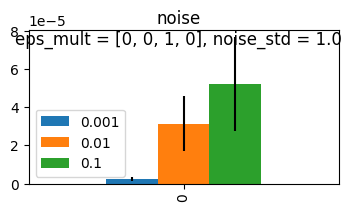

hparams_min=('test_loss', 0.001)


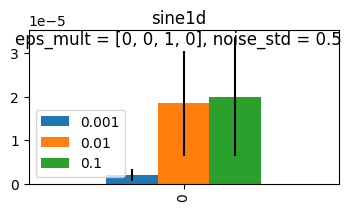

hparams_min=('test_loss', 0.001)


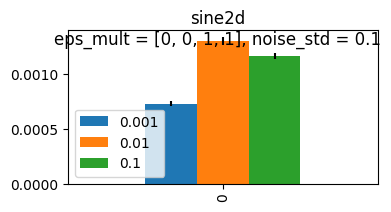

hparams_min=('test_loss', 0.001)


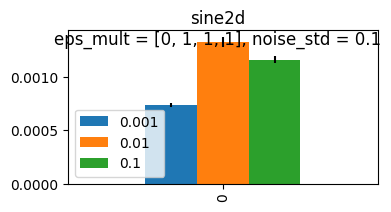

hparams_min=('test_loss', 0.01)


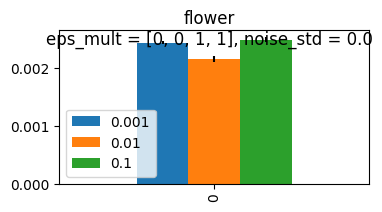

hparams_min=('test_loss', 0.01)


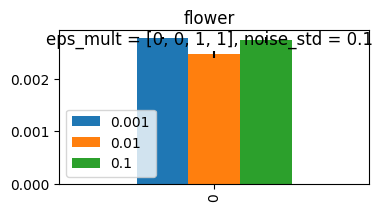

hparams_min=('test_loss', 0.01)


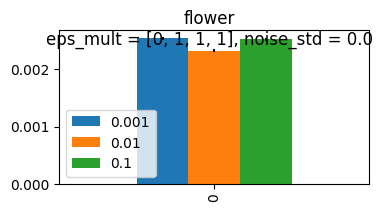

hparams_min=('test_loss', 0.01)


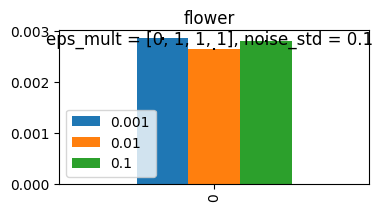

hparams_min=('test_loss', 0.01)


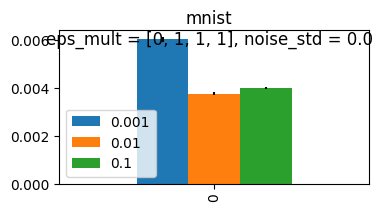

hparams_min=('test_loss', 0.01)


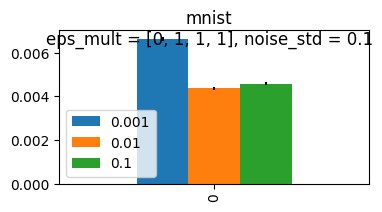

test_loss                       \
lr                                                 0.001                 0.01   
dataset_name eps_mult     noise_std                                             
noise        [0, 0, 1, 0] 1.0        2.35e-06 ± 9.03e-07  3.14e-05 ± 1.44e-05   
sine1d       [0, 0, 1, 0] 0.5        1.97e-06 ± 1.33e-06  1.84e-05 ± 1.20e-05   
sine2d       [0, 0, 1, 1] 0.1        7.29e-04 ± 2.09e-05  1.30e-03 ± 3.67e-05   
             [0, 1, 1, 1] 0.1        7.42e-04 ± 1.93e-05  1.33e-03 ± 4.79e-05   
flower       [0, 0, 1, 1] 0.0        2.45e-03 ± 3.39e-05  2.16e-03 ± 4.71e-05   
                          0.1        2.78e-03 ± 1.55e-05  2.47e-03 ± 6.57e-05   
             [0, 1, 1, 1] 0.0        2.55e-03 ± 2.60e-05  2.33e-03 ± 2.82e-05   
                          0.1        2.86e-03 ± 2.85e-05  2.65e-03 ± 2.81e-05   
mnist        [0, 1, 1, 1] 0.0        6.03e-03 ± 1.06e-04  3.76e-03 ± 5.33e-05   
                          0.1        6.64e-03 ± 1.01e-04  4.37e-03 ± 7.66e-05   

                                                          
lr                                                   0.1  
dataset_name eps_mult     noise_std                       
noise        [0, 0, 1, 0] 1.0        5.21e-05 ± 2.46e-05  
sine1d       [0, 0, 1, 0] 0.5        2.00e-05 ± 1.38e-05  
sine2d       [0, 0, 1, 1] 0.1        1.16e-03 ± 2.59e-05  
             [0, 1, 1, 1] 0.1        1.17e-03 ± 3.68e-05  
flower       [0, 0, 1, 1] 0.0        2.50e-03 ± 4.89e-05  
                          0.1        2.75e-03 ± 5.63e-05  
             [0, 1, 1, 1] 0.0        2.53e-03 ± 2.47e-05  
                          0.1        2.81e-03 ± 2.22e-05  
mnist        [0, 1, 1, 1] 0.0        3.99e-03 ± 5.34e-05  
                          0.1        4.59e-03 ± 8.00e-05

In [11]:
group_params = ['eps_mult', 'noise_std']
hyper_params  = ['lr']

datasets_predict = {
    'noise' : {'log' : False},
    'sine1d' : {'log' : False},
    'sine2d' : {'log' : False},
    'flower' : {'log' : False},
    'mnist' : {'log' : False},
}

d_pivots = {}
index_columns = ['dataset_name'] + group_params
dds = []
dds_mean = []
dds_std = []

mins = []

for dataset_name, dataset_info in datasets_predict.items():
    d = df[df['tags'].astype(str).str.contains(f"'{dataset_name}'")].reset_index(drop=True)
    d = d[~d['tags'].astype(str).str.contains(f'predict')].reset_index(drop=True)

    d = stringify_dict(d, group_params)
    ds = {group : d_group for group, d_group in d.groupby(group_params)} if group_params else {0 : d}


    for group, d in ds.items():

        d = d.reset_index(drop=True)

        for row in d['data_kwargs']:
            if 'grid_size' in row:
                row['grid_size'] = tuple(row['grid_size'])
        for row in d['transform_kwargs']:
            if 'eps_mult' in row:
                row['eps_mult'] = [float(x) for x in row['eps_mult']]

        d = d.drop_duplicates(subset=hyper_params + ['seed', 'test_loss']) #TODO: why is this necessary?
        map_kwargs = assert_columns_same(d, ['data_kwargs', 'transform_kwargs', 'data_dir'])

        d_pivot = pivot(d, columns = hyper_params)
        # d_pivot = rename_net(d_pivot)
        d_pivots[(dataset_name, group)] = dict(d_pivot=d_pivot, map_kwargs=map_kwargs)

        dd = pd.DataFrame(data = [f'{mean:.2e} ± {std:.2e}' for mean, std in zip(d_pivot.mean().values, d_pivot.std().values)], index = d_pivot.columns).T
        dd_mean = pd.DataFrame(data = [mean for mean in d_pivot.mean().values], index = d_pivot.columns).T
        dd_std = pd.DataFrame(data = [std for std in d_pivot.std().values], index = d_pivot.columns).T

        for dd_i, dds_i in zip([dd, dd_mean, dd_std], [dds, dds_mean, dds_std]):

            dd_i[index_columns] = [dataset_name] + list(group)
            dd_i = dd_i.set_index(index_columns)
            dds_i.append(dd_i)

        # continue


        hparams_min = d_pivot.mean().idxmin()
        assert len(hparams_min) == 2
        df_map_new = d[d[hyper_params[0]] == hparams_min[1]][df_map_columns]
        add_df_map_new(df_map_new)
        # Ps = get_and_check_Ps(df_map_new['seed'].unique(), map_kwargs)
        # plot2d(Ps, l = 2, max_grid = 40)

        print(f'{hparams_min=}')
        mins.append((dataset_name, group, hparams_min))
        suptitle = dataset_name + '\n' + ', '.join([f'{group_param} = {group_el}' for group_param, group_el in zip(group_params, group)]) if group != 0 else dataset_name
        plot_pivot(d_pivot=d_pivot, legend_loc = 'lower left', logx=dataset_info['log'], suptitle = suptitle, figsize = (4, 2))



ddd = pd.concat(dds)
ddd_mean = pd.concat(dds_mean)
ddd_std = pd.concat(dds_std)
ddd

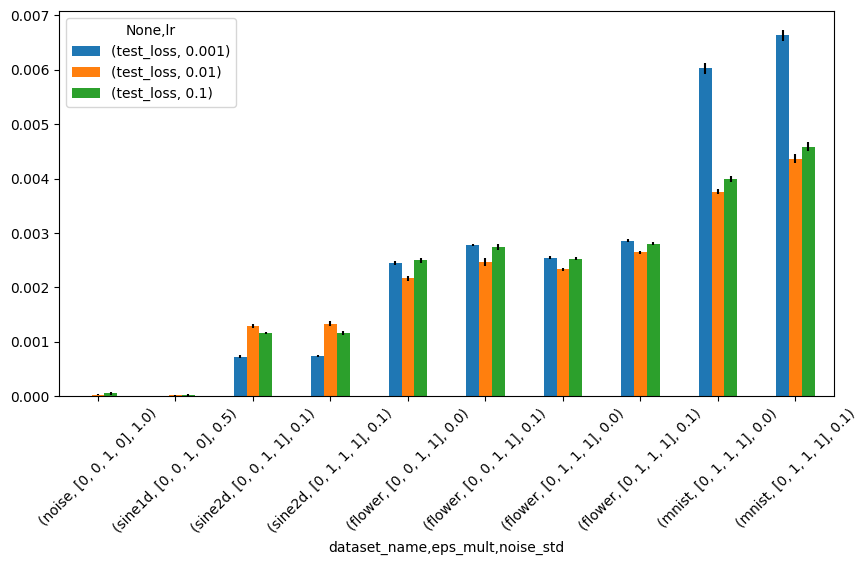

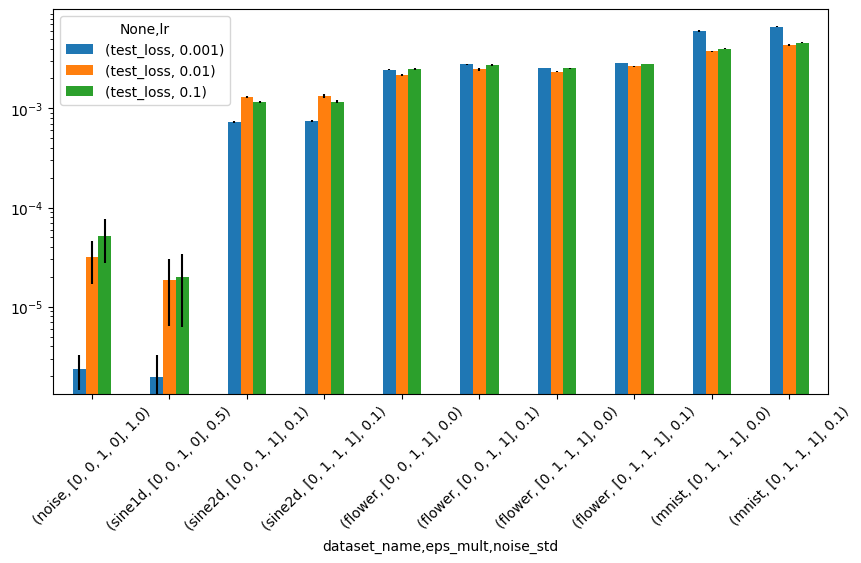

In [12]:
for logy in [False, True]:
    ddd_mean.plot(kind='bar', yerr = ddd_std, figsize = (10, 5), logy = logy, rot = 45)
    plt.show()

In [13]:
d = df.copy()

d = d[~d['tags'].astype(str).str.contains('predict')].reset_index(drop=True)
d = stringify_dict(d, group_params)

dd = d.groupby(['data_dir'] + group_params + hyper_params + ['seed']).count()
print(dd[dd['test_loss'] > 1].index.values)

# d = d.pivot(index = ['data_dir'] + group_params , columns = hyper_params +  ['seed'], values = 'test_loss')

d = pivot(d, index = ['data_dir'] + group_params, columns = hyper_params + ['seed'], values = 'test_loss')

# d[d.isna().any(axis=0)]

d

[]


test_loss                          \
lr                                        0.001                           
seed                                          1         2             3   
data_dir       eps_mult     noise_std                                     
../data/MNIST  [0, 1, 1, 1] 0.0        0.005908  0.006070  6.106423e-03   
                            0.1        0.006522  0.006697  6.695856e-03   
../data/flower [0, 0, 1, 1] 0.0        0.002410  0.002474  2.461516e-03   
                            0.1             NaN  0.002790  2.768013e-03   
               [0, 1, 1, 1] 0.0        0.002523  0.002541  2.574432e-03   
                            0.1        0.002839       NaN  2.879147e-03   
../data/noise  [0, 0, 1, 0] 1.0        0.000001  0.000003  3.139227e-06   
../data/sine1d [0, 0, 1, 0] 0.5        0.000003  0.000002  7.786539e-07   
../data/sine2d [0, 0, 1, 1] 0.1        0.000727  0.000751  7.092459e-04   
               [0, 1, 1, 1] 0.1        0.000720  0.000750  7.562639e-04   

                                                                               \
lr                                        0.010                         0.100   
seed                                          1         2         3         1   
data_dir       eps_mult     noise_std                                           
../data/MNIST  [0, 1, 1, 1] 0.0        0.003705  0.003810  0.003772  0.003931   
                            0.1        0.004315  0.004423       NaN  0.004498   
../data/flower [0, 0, 1, 1] 0.0        0.002111  0.002185  0.002198  0.002442   
                            0.1        0.002394  0.002520  0.002488  0.002681   
               [0, 1, 1, 1] 0.0             NaN  0.002313  0.002353  0.002507   
                            0.1        0.002638  0.002627  0.002680  0.002816   
../data/noise  [0, 0, 1, 0] 1.0        0.000015  0.000036  0.000043       NaN   
../data/sine1d [0, 0, 1, 0] 0.5        0.000024  0.000027  0.000005  0.000028   
../data/sine2d [0, 0, 1, 1] 0.1        0.001295  0.001340  0.001267  0.001144   
               [0, 1, 1, 1] 0.1        0.001277  0.001364  0.001356  0.001125   

                                                           
lr                                                         
seed                                          2         3  
data_dir       eps_mult     noise_std                      
../data/MNIST  [0, 1, 1, 1] 0.0        0.004032  0.004012  
                            0.1        0.004649  0.004620  
../data/flower [0, 0, 1, 1] 0.0        0.002532  0.002520  
                            0.1        0.002772  0.002785  
               [0, 1, 1, 1] 0.0        0.002527  0.002556  
                            0.1        0.002782  0.002824  
../data/noise  [0, 0, 1, 0] 1.0        0.000035  0.000070  
../data/sine1d [0, 0, 1, 0] 0.5        0.000028  0.000004  
../data/sine2d [0, 0, 1, 1] 0.1        0.001180       NaN  
               [0, 1, 1, 1] 0.1        0.001195  0.001181

## Map

In [14]:
def filter_on_tags(df, tags):
    return df[df['tags'].astype(str).str.contains('|'.join(tags))]

In [15]:
df_map = pd.read_pickle('../logs/store/map_df.pkl')

df_map_sync = filter_on_tags(df_map, tags = ['sine1d', 'noise'])
df_map_sync = df_map_sync.reset_index(drop=True)
df_map_sync

,run_id,tags,data_kwargs,transform_kwargs,seed,data_dir
0,3gi8lu9g,"['new', 'sine1d']","{'y_low': 1, 'y_high': 3, 'grid_size': (1, 7),...","{'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip'...",3,../data/sine1d
1,lh3nnnij,"['new', 'sine1d']","{'y_low': 1, 'y_high': 3, 'grid_size': (1, 7),...","{'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip'...",2,../data/sine1d
2,cpw6d6pz,"['new', 'sine1d']","{'y_low': 1, 'y_high': 3, 'grid_size': (1, 7),...","{'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip'...",1,../data/sine1d
3,vjewun0b,"['hparam', 'noise']","{'grid_size': (1, 7), 'noise_std': 1}","{'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip'...",3,../data/noise
4,g41hidqj,"['hparam', 'noise']","{'grid_size': (1, 7), 'noise_std': 1}","{'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip'...",2,../data/noise
5,xxidyaps,"['hparam', 'noise']","{'grid_size': (1, 7), 'noise_std': 1}","{'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip'...",1,../data/noise


In [16]:
sync_run_ids = list(df_map_sync['run_id'].values)

store_dir = '../logs/store'
# write the run_ids to a txt file
with open(os.path.join(store_dir, 'sync_run_ids.txt'), 'w') as f:
    f.write(f"{{{','.join(sync_run_ids)}}}")

In [17]:
d = filter_on_tags(df_map_sync, tags = ['sine1d'])
map_kwargs = assert_columns_same(d, ['data_kwargs', 'transform_kwargs', 'data_dir'])
map_kwargs

{'data_kwargs': {'y_low': 1,
  'y_high': 3,
  'grid_size': (1, 7),
  'noise_std': 0.5},
 'transform_kwargs': {'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip': False},
 'data_dir': '../data/sine1d'}

In [37]:
import ast

In [42]:
for i in df_map.data_kwargs:
    pass



[(7, 7),
 (7, 7),
 (1, 7),
 (1, 7),
 (1, 7),
 (7, 7),
 (7, 7),
 (7, 7),
 (7, 7),
 (7, 7),
 (7, 7),
 (10, 10),
 (10, 10),
 (10, 10),
 (10, 10),
 (10, 10),
 (10, 10),
 (10, 10),
 (10, 10),
 (10, 10),
 (10, 10),
 (7, 7),
 (7, 7),
 (7, 7),
 (10, 10),
 (1, 7),
 (1, 7),
 (1, 7)]

In [32]:
df_map = pd.read_pickle('../logs/store/map_df.pkl')
df_map.data_kwargs.astype(str).str.contains('grid_size')

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
20    True
21    True
22    True
23    True
24    True
25    True
26    True
27    True
Name: data_kwargs, dtype: bool

Found run_id vjewun0b
Found run_id g41hidqj
Found run_id xxidyaps


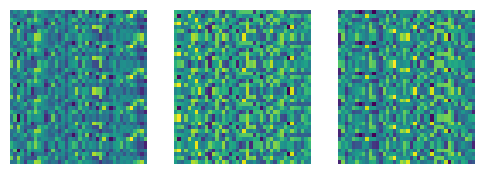

In [50]:
Ps = get_and_check_Ps(d['seed'].unique(), map_kwargs, use_P_from_noise = True)
# Ps = get_and_check_Ps([1], map_kwargs)
plot2d(Ps, l = 2, max_grid = 40)